# Full Artificial Neural Network
In the last section we took in four continuous variables (lengths) to perform a classification. In this section we'll combine continuous and categorical data to perform a regression. The goal is to estimate the cost of a New York City cab ride from several inputs. The inspiration behind this code along is a recent <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a>.

<div class="alert alert-success"><strong>NOTE:</strong> In this notebook we'll perform a regression with one output value. In the next one we'll perform a binary classification with two output values.</div>

## Working with tabular data
Deep learning with neural networks is often associated with sophisticated image recognition, and in upcoming sections we'll train models based on properties like pixels patterns and colors.

Here we're working with tabular data (spreadsheets, SQL tables, etc.) with columns of values that may or may not be relevant. As it happens, neural networks can learn to make connections we probably wouldn't have developed on our own. However, to do this we have to handle categorical values separately from continuous ones. Make sure to watch the theory lectures! You'll want to be comfortable with:
* continuous vs. categorical values
* embeddings
* batch normalization
* dropout layers

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

From this we see that fares range from \\$2.50 to \\$49.90, with a mean of \\$10.04 and a median of \\$7.70

#### Our ANN might not be able to make good sense of latitude and longitude. Plus since the dataset is for NY city, the lat and longs are very close so it'll be more difficult for ANN to learn from this feature

#### Instead, what could be useful is the distance between pickup and dropoff lat/longs

## Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [5]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 13 columns):
pickup_datetime      120000 non-null object
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
dist_km              120000 non-null float64
EDTdate              120000 non-null datetime64[ns]
Hour                 120000 non-null int64
AMorPM               120000 non-null object
Weekday              120000 non-null object
dtypes: datetime64[ns](1), float64(6), int64(3), object(3)
memory usage: 11.9+ MB


## Add a datetime column and derive useful statistics
By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc.
Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [7]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


## Separate categorical from continuous columns

In [9]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [10]:
# NOTE: hour can be interpreted as either continous or discrete feature

cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels

## Categorify
Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. A dataset containing months of the year will be assigned 12 codes, one for each month. These will usually be the integers 0 to 11. Pandas replaces the column values with codes, and retains an index list of category values. In the steps ahead we'll call the categorical values "names" and the encodings "codes".<br>
<br>
This is another way creating dummy variables

In [11]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [12]:
df

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.50,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.90,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.10,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.90,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.70,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri
5,2010-04-22 08:39:47 UTC,8.10,0,-73.980481,40.748995,-73.983508,40.766459,1,1.958574,2010-04-22 04:39:47,4,am,Thu
6,2010-04-23 19:27:00 UTC,4.90,0,-73.959535,40.779582,-73.947185,40.780223,1,1.042304,2010-04-23 15:27:00,15,pm,Fri
7,2010-04-15 09:03:37 UTC,4.90,0,-74.002601,40.739419,-73.997912,40.730292,1,1.089064,2010-04-15 05:03:37,5,am,Thu
8,2010-04-20 08:58:00 UTC,2.90,0,-74.014005,40.704058,-74.013202,40.702877,1,0.147740,2010-04-20 04:58:00,4,am,Tue
9,2010-04-16 18:50:16 UTC,6.10,0,-73.977689,40.784175,-73.988639,40.778669,1,1.106731,2010-04-16 14:50:16,14,pm,Fri


In [13]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

Here our categorical names are the integers 0 through 23, for a total of 24 unique categories. These values <em>also</em> correspond to the codes assigned to each name.

In [14]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [15]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [19]:
# AM assigned 0, PM assigned 1
df['AMorPM'].cat.codes.head(10)

0    0
1    0
2    0
3    1
4    1
5    0
6    1
7    0
8    0
9    1
dtype: int8

#### To convert these categorical variables to tensors, we first have to convert them into a stacked numpy array

In [20]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

In [21]:
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

#### Now its a stacked array of smaller arrays where each smaller array represent: [hour, AMorPM, wkday]

<div class="alert alert-info"><strong>NOTE:</strong> This can be done in one line of code using a list comprehension:
<pre style='background-color:rgb(217,237,247)'>cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)</pre>

Don't worry about the dtype for now, we can make it int64 when we convert it to a tensor.</div>

## Convert numpy arrays to tensors

In [22]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64) 
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

We can feed all of our continuous variables into the model as a tensor. Note that we're not normalizing the values here; we'll let the model perform this step.
<div class="alert alert-info"><strong>NOTE:</strong> We have to store <tt>conts</tt> and <tt>y</tt> as Float (float32) tensors, not Double (float64) in order for batch normalization to work properly.</div>

In [23]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

#### So far, we have the categorical features are a tensor and continous features as tensor
#### Now we need to convert our label to a tensor

In [24]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [25]:
cats.shape

torch.Size([120000, 3])

In [26]:
conts.shape

torch.Size([120000, 6])

In [27]:
y.shape

torch.Size([120000, 1])

## Set an embedding size
The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

embedding is a pytorch specific procedure. It's like one-hot-encoding on categorical features<br>
It's mostly useful for categorizing words for text data. Each word is assigned an index. 
<br>Very similar to vectorization in Python's NLP

In [30]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays

# cat_szs holds the number unique values for each category in list format
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
cat_szs

[24, 2, 7]

This means that there are 24 unique values for the first category (which is Hours)<br>
This means that there are 2 unique values for the second category (which is AMorPM)<br>
This means that there are 7 unique values for the third category (which is Weekday)<br>

In [42]:
# Creates a list of tuples: (no. of unique values, half the no. of unique values)
# this will later be needed for our tabular model

emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

## Define a TabularModel
This somewhat follows the <a href='https://docs.fast.ai/tabular.models.html'>fast.ai library</a> The goal is to define a model based on the number of continuous columns (given by <tt>conts.shape[1]</tt>) plus the number of categorical columns and their embeddings (given by <tt>len(emb_szs)</tt> and <tt>emb_szs</tt> respectively). The output would either be a regression (a single float value), or a classification (a group of bins and their softmax values). For this exercise our output will be a single regression value. Note that we'll assume our data contains both categorical and continuous data. You can add boolean parameters to your own model class to handle a variety of datasets.

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take. See below for more detailed illustrations of the steps.</strong><br>

1. Extend the base Module class, set up the following parameters:
   * <tt>emb_szs: </tt>list of tuples: each categorical variable size is paired with an embedding size
   * <tt>n_cont:  </tt>int: number of continuous variables
   * <tt>out_sz:  </tt>int: output size
   * <tt>layers:  </tt>list of ints: layer sizes
   * <tt>p:       </tt>float: dropout probability for each layer (for simplicity we'll use the same value throughout)
   
<tt><font color=black>class TabularModel(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, emb_szs, n_cont, out_sz, layers, p=0.5):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the embedded layers with <a href='https://pytorch.org/docs/stable/nn.html#modulelist'><tt><strong>torch.nn.ModuleList()</strong></tt></a> and <a href='https://pytorch.org/docs/stable/nn.html#embedding'><tt><strong>torch.nn.Embedding()</strong></tt></a><br>Categorical data will be filtered through these Embeddings in the forward section.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])</font></tt><br><br>
3. Set up a dropout function for the embeddings with <a href='https://pytorch.org/docs/stable/nn.html#dropout'><tt><strong>torch.nn.Dropout()</strong></tt></a> The default p-value=0.5<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.emb_drop = nn.Dropout(emb_drop)</font></tt><br><br>
4. Set up a normalization function for the continuous variables with <a href='https://pytorch.org/docs/stable/nn.html#batchnorm1d'><tt><strong>torch.nn.BatchNorm1d()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)</font></tt><br><br>
5. Set up a sequence of neural network layers where each level includes a Linear function, an activation function (we'll use <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong>ReLU</strong></a>), a normalization step, and a dropout layer. We'll combine the list of layers with <a href='https://pytorch.org/docs/stable/nn.html#sequential'><tt><strong>torch.nn.Sequential()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_emb = sum((nf for ni,nf in emb_szs))<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_in = n_emb + n_cont<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i in layers:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(n_in,i)) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.ReLU(inplace=True))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.BatchNorm1d(i))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Dropout(p))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;n_in = i<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(layers[-1],out_sz))<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;self.layers = nn.Sequential(*layerlist)</font></tt><br><br>
6. Define the forward method. Preprocess the embeddings and normalize the continuous variables before passing them through the layers.<br>Use <a href='https://pytorch.org/docs/stable/torch.html#torch.cat'><tt><strong>torch.cat()</strong></tt></a> to combine multiple tensors into one.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;def forward(self, x_cat, x_cont):<br>
&nbsp;&nbsp;&nbsp;&nbsp;embeddings = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i,e in enumerate(self.embeds):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;embeddings.append(e(x_cat[:,i]))<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat(embeddings, 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.emb_drop(x)<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;x_cont = self.bn_cont(x_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat([x, x_cont], 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.layers(x)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return x</font></tt>
</div>

<div class="alert alert-danger"><strong>Breaking down the embeddings steps</strong> (this code is for illustration purposes only.)</div>

In [43]:
# Let's work with this small fragment of categorical data
# The next few steps shows what the TabularModel class does

catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [33]:
# This happends inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [34]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [35]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[-0.8974, -1.8966,  0.2460, -0.8534,  1.4083, -0.9253, -2.2061,  0.8530,
           2.0354, -0.0904,  1.7622,  0.7604],
         [ 0.3518, -2.1296, -0.6207, -2.0451,  0.9209, -0.3780,  1.1810, -0.5719,
          -1.4823, -0.6825, -0.7690,  0.4383],
         [ 0.1289,  0.4480, -0.8503, -1.4969,  0.2017, -0.2243,  0.0338, -0.4901,
           0.1686,  0.9922,  1.2052,  0.6885],
         [-0.3488, -0.3773, -0.2029,  0.2056,  1.3722,  0.0818, -0.4283, -0.8627,
          -1.4865,  0.3581,  0.4240, -0.3110]], grad_fn=<EmbeddingBackward>),
 tensor([[ 0.3952],
         [ 0.3952],
         [ 0.3952],
         [-2.9787]], grad_fn=<EmbeddingBackward>),
 tensor([[-1.5766, -0.2172,  0.5295, -0.1214],
         [-0.6501, -0.2284, -0.5720, -0.2335],
         [-0.6501, -0.2284, -0.5720, -0.2335],
         [-0.4090,  0.8222, -0.9882,  0.2869]], grad_fn=<EmbeddingBackward>)]

What you're seeing here is a vector/list representation of each categorical value <br>
There are 3 tensors since there are 3 different categories (hour, am/pm, wkday)

#### 1st tensor:
$[-0.8974, -1.8966,  0.2460, -0.8534,  1.4083, -0.9253, -2.2061,  0.8530, 2.0354, -0.0904,  1.7622,  0.7604]$ as a whole represents 4 from catz  <br>
$[ 0.3518, -2.1296, -0.6207, -2.0451,  0.9209, -0.3780,  1.1810, -0.5719, -1.4823, -0.6825, -0.7690,  0.4383]$ as a whole represents 11 from catz <br>
<b>Note</b> that there are 12 elements in each array since we set embedding size to 12 for hours <br>

#### 2nd tensor:
$[ 0.3952]$ represents 0 or AM from catz <br>
$[-2.9787]$ represents 1 or PM from catz<br>
<b>Note</b> that there is just 1 element in each array since we set embedding size to 1 for am/pm <br>

#### 3rd tensor:
Same way, each array represents a weekday

In [37]:
# We concatenate the embedding sections (12,1,4) into one (17)
# Here, cat means concatenate
# 1 means 1-dim

z = torch.cat(embeddingz, 1)
z

tensor([[-0.8974, -1.8966,  0.2460, -0.8534,  1.4083, -0.9253, -2.2061,  0.8530,
          2.0354, -0.0904,  1.7622,  0.7604,  0.3952, -1.5766, -0.2172,  0.5295,
         -0.1214],
        [ 0.3518, -2.1296, -0.6207, -2.0451,  0.9209, -0.3780,  1.1810, -0.5719,
         -1.4823, -0.6825, -0.7690,  0.4383,  0.3952, -0.6501, -0.2284, -0.5720,
         -0.2335],
        [ 0.1289,  0.4480, -0.8503, -1.4969,  0.2017, -0.2243,  0.0338, -0.4901,
          0.1686,  0.9922,  1.2052,  0.6885,  0.3952, -0.6501, -0.2284, -0.5720,
         -0.2335],
        [-0.3488, -0.3773, -0.2029,  0.2056,  1.3722,  0.0818, -0.4283, -0.8627,
         -1.4865,  0.3581,  0.4240, -0.3110, -2.9787, -0.4090,  0.8222, -0.9882,
          0.2869]], grad_fn=<CatBackward>)

In [39]:
# This happends under the __init__() method
# Creating a dropout layer to prevent overfitting

selfembdrop = nn.Dropout(.4)

In [41]:
# Applying dropout layer on z
z = selfembdrop(z)
z

tensor([[-0.0000, -0.0000,  0.0000, -2.3705,  0.0000, -0.0000, -0.0000,  2.3694,
          5.6538, -0.2511,  4.8951,  2.1123,  0.0000, -4.3795, -0.0000,  0.0000,
         -0.0000],
        [ 0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
         -0.0000, -0.0000, -2.1360,  1.2176,  0.0000, -0.0000, -0.6343, -0.0000,
         -0.6486],
        [ 0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.6230,  0.0000, -0.0000,
          0.4683,  2.7561,  3.3478,  1.9126,  0.0000, -1.8058, -0.0000, -0.0000,
         -0.6486],
        [-0.9689, -1.0480, -0.0000,  0.0000,  3.8116,  0.0000, -0.0000, -2.3963,
         -4.1291,  0.9948,  1.1777, -0.8639, -8.2743, -0.0000,  2.2838, -0.0000,
          0.0000]], grad_fn=<MulBackward0>)

<div class="alert alert-danger"><strong>This is how the categorical embeddings are passed into the layers.</strong></div>

In [44]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        
        # Create embeddings using emedding size emb_szs and then pass them through the dropout layer
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        # Sum all the emb_szs for all category
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            
            # No. of output becomes no. of inputs in next layer
            n_in = i
            
        # Output layer. layers[-1] has the no. of nodes for output layers
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        # Combine the categorical embeds tensors with the continous tensors to create one big features tensor
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [47]:
torch.manual_seed(33)

# n_conts is number of continous features
# emb_szs is has embed size for each cat features
model = TabularModel(emb_szs=emb_szs, n_cont=conts.shape[1], out_sz=1, layers=[200,100], p=0.4)

In [48]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## Define loss function & optimizer
PyTorch does not offer a built-in <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'>RMSE Loss</a> function, and it would be nice to see this in place of MSE.<br>
For this reason, we'll simply apply the <tt>torch.sqrt()</tt> function to the output of MSELoss during training.

In [49]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Perform train/test splits
At this point our batch size is the entire dataset of 120,000 records. This will take a long time to train, so you might consider reducing this. We'll use 60,000. Recall that our tensors are already randomly shuffled.

In [51]:
cats

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  1,  2]])

In [52]:
conts

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        ...,
        [ 40.7498, -73.9886,  40.7078, -74.0115,   3.0000,   5.0525],
        [ 40.7245, -74.0044,  40.7308, -73.9927,   1.0000,   1.2089],
        [ 40.7719, -73.9554,  40.7630, -73.9676,   3.0000,   1.4274]])

In [50]:
batch_size = 60000
test_size = int(batch_size * .2)

# Dataset has been shuffled already
# Basically what's happening here is we will take datasets into batches of 60,000 data
# Let's say batch_size-test_size = 48000, we are slicing the first 48000 rows in cat_train data
# Then we are slicing the rest of the data (index 48001 to 60000) as cat_test data

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [53]:
cat_train

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [ 0,  0,  0],
        [ 8,  0,  4],
        [23,  1,  2]])

In [54]:
y_train

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [ 3.3000],
        [ 6.9000],
        [18.1000]])

## Train the model
Expect this to take 30 minutes or more! We've added code to tell us the duration at the end.

In [55]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    # model obj is calling the forward method
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.49953079
epoch:  26  loss: 11.52666759
epoch:  51  loss: 10.47162437
epoch:  76  loss: 9.53090572
epoch: 101  loss: 8.72837734
epoch: 126  loss: 7.81541204
epoch: 151  loss: 6.70775080
epoch: 176  loss: 5.48522472
epoch: 201  loss: 4.37022400
epoch: 226  loss: 3.70549846
epoch: 251  loss: 3.51685023
epoch: 276  loss: 3.44736743
epoch: 300  loss: 3.42487454

Duration: 652 seconds


## Plot the loss function

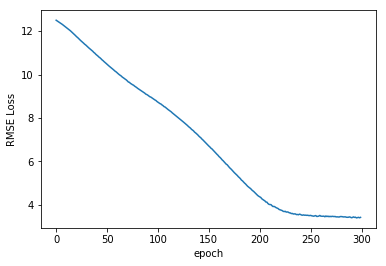

In [56]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

## Validate the model
Here we want to run the entire test set through the model, and compare it to the known labels.<br>
For this step we don't want to update weights and biases, so we set <tt>torch.no_grad()</tt>

In [57]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    # model obj is calling the forward method
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.34569192


This means that on average, predicted values are within &plusmn;$3.31 of the actual value.

Now let's look at the first 50 predicted values:

In [58]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   2.5258   2.9000   0.3742
 2.  25.0885   5.7000  19.3885
 3.   6.3869   7.7000   1.3131
 4.  13.5297  12.5000   1.0297
 5.   4.4957   4.1000   0.3957
 6.   4.9116   5.3000   0.3884
 7.   3.1296   3.7000   0.5704
 8.  17.7939  14.5000   3.2939
 9.   6.1307   5.7000   0.4307
10.  12.0632  10.1000   1.9632
11.   6.0902   4.5000   1.5902
12.   6.8988   6.1000   0.7988
13.   5.9466   6.9000   0.9534
14.  13.4745  14.1000   0.6255
15.   5.9154   4.5000   1.4154
16.  27.5576  34.1000   6.5424
17.   3.3297  12.5000   9.1703
18.   5.7631   4.1000   1.6631
19.   8.2568   8.5000   0.2432
20.   6.2824   5.3000   0.9824
21.  13.6508  11.3000   2.3508
22.   9.6946  10.5000   0.8054
23.  16.0124  15.3000   0.7124
24.  19.2758  14.9000   4.3758
25.  48.6202  49.5700   0.9498
26.   6.3326   5.3000   1.0326
27.   6.0473   3.7000   2.3473
28.   7.1369   6.5000   0.6369
29.  15.0696  14.1000   0.9696
30.   6.7617   4.9000   1.8617
31.   4.3687   3.7000   0.6687
32.  35.

So while many predictions were off by a few cents, some were off by \\$19.00. Feel free to change the batch size, test size, and number of epochs to obtain a better model.

## Save the model
We can save a trained model to a file in case we want to come back later and feed new data through it. The best practice is to save the state of the model (weights & biases) and not the full definition. Also, we want to ensure that only a trained model is saved, to prevent overwriting a previously saved model with an untrained one.<br>For more information visit <a href='https://pytorch.org/tutorials/beginner/saving_loading_models.html'>https://pytorch.org/tutorials/beginner/saving_loading_models.html</a>

In [59]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

#### The rest is:
#### * Loading a saved model from scratch
#### * Feed new (user input) data through the trained model

#### They are in the tutorial notebook